In [7]:
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve



## 1. Forward Kinematics

#### 1.2 DH function that takes DH parameters and outputs transformation matrices

In [2]:
def DH(theta, d, a, alpha):
    num_joints = len(theta)
    TM = []

    for i in range(num_joints):
        A = np.array([
            [np.cos(theta[i]), -np.sin(theta[i]) * np.cos(alpha[i]),  np.sin(theta[i]) * np.sin(alpha[i]), a[i] * np.cos(theta[i])],
            [np.sin(theta[i]),  np.cos(theta[i]) * np.cos(alpha[i]), -np.cos(theta[i]) * np.sin(alpha[i]), a[i] * np.sin(theta[i])],
            [0,                 np.sin(alpha[i]),                    np.cos(alpha[i]),                    d[i]],
            [0,                 0,                                    0,                                    1]
        ])
        
        TM.append(A)
    
    return TM


#### 1.3 FK function that takes joint angles and outputs the eef pose 

In [2]:
def forward_kinematics(theta, d, a, alpha):
    transformation_matrices = DH(theta, d, a, alpha)

    T = np.eye(4)  # Initialize as identity matrix

    for transformation in transformation_matrices:
        T = T @ transformation
        
    position = T[0:3, 3]
    orientation = T[0:3, 0:3]

    # Create the end-effector pose
    end_effector_pose = {
        'position': position,
        'orientation': orientation
    }

    return end_effector_pose


#### 1.4 Simulating a 3R Ortho Parallel robot

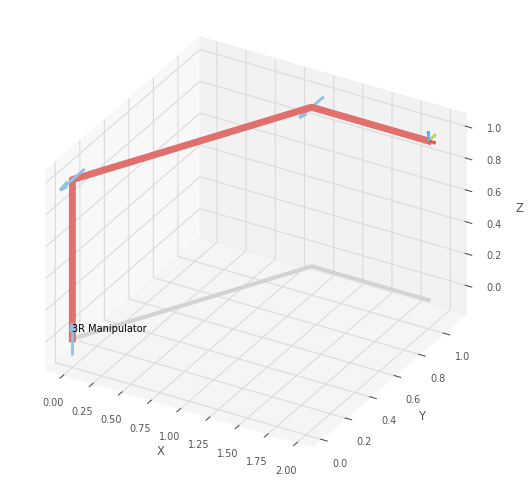

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, '3R Manipulator')

<Figure size 640x480 with 0 Axes>

In [191]:

# Create links with DH parameters: theta, d, a, alpha
link1 = rtb.RevoluteDH(d=1, a=0, alpha=np.pi/2)     
link2 = rtb.RevoluteDH(d=-1, a=1, alpha=0)            
link3 = rtb.RevoluteDH(d=0, a=1, alpha=-np.pi/2)      

robot = rtb.DHRobot([link1, link2, link3], name="3R Manipulator")

home_configuration = [0, 0, 0]

robot.plot(home_configuration, backend="pyplot")


## 2. Inverse Kinematics

#### 2.2 IK function that takes eef pose and outputs the joint angles

In [275]:
def inverse_kinematics(x, y, z):
    def equations(angles):
        theta1, theta2, theta3 = angles
        X = -np.sin(theta1) + np.cos(theta1)*np.cos(theta2) + np.cos(theta1)*np.cos(theta2 + theta3)
        Y = np.cos(theta1) + np.sin(theta1)*np.cos(theta2) + np.sin(theta1)*np.cos(theta2 + theta3)
        Z = 1 + np.sin(theta2) + np.sin(theta2 + theta3)
        return [X - x, Y - y, Z - z]

    initial_guess = np.random.randn(3)/2
    solution = fsolve(equations, initial_guess)
    
    return solution

def add_vector_to_list(new_vector, vector_list):
    return (np.sum(np.abs(vector_list - new_vector), axis=-1) > 2).all()
        
        
x, y, z = 1.0, 1.5, 0.1 # example eef pose of (1, 1, 1)
outputs = []

for i in range(1000):
    output = inverse_kinematics(x, y, z)
    if len(outputs) == 0:
        outputs = [output % 6.28]
    if add_vector_to_list(output % 6.28, outputs):
        outputs.append(output % 6.28)

outputs = np.array(outputs)
outputs

array([[0.39479112, 6.24567838, 5.26780424],
       [0.39479112, 5.23348262, 1.01219576],
       [4.70920367, 3.18228489, 0.99626923],
       [4.70920367, 4.18492473, 5.26780424],
       [0.39479112, 0.03575513, 5.12765073]])

#### 2.3 Different IK solutions of the same eef position

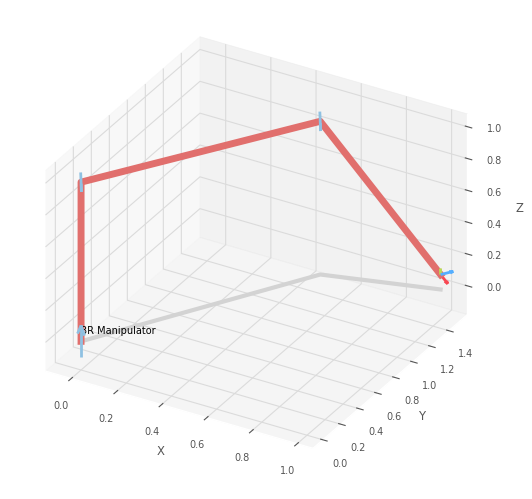

EEF position: [0.99479436 1.49783098 0.09364528]


<Figure size 640x480 with 0 Axes>

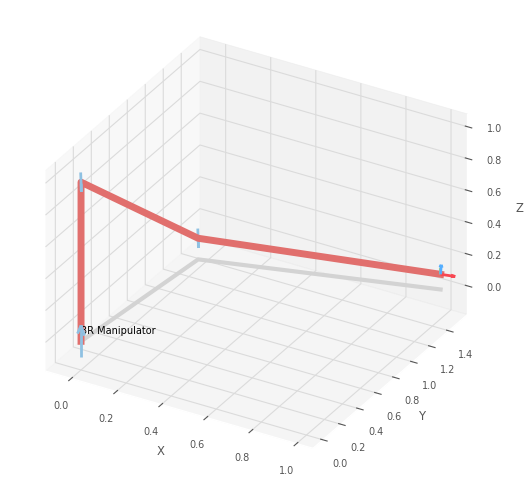

EEF position: [0.99734673 1.49889447 0.09522661]


<Figure size 640x480 with 0 Axes>

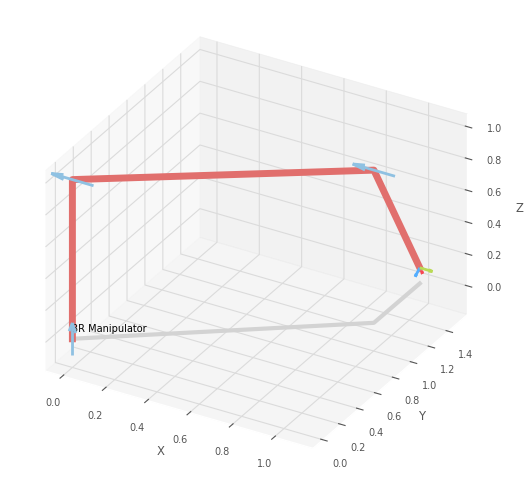

EEF position: [1.0047984  1.5048176  0.09845692]


<Figure size 640x480 with 0 Axes>

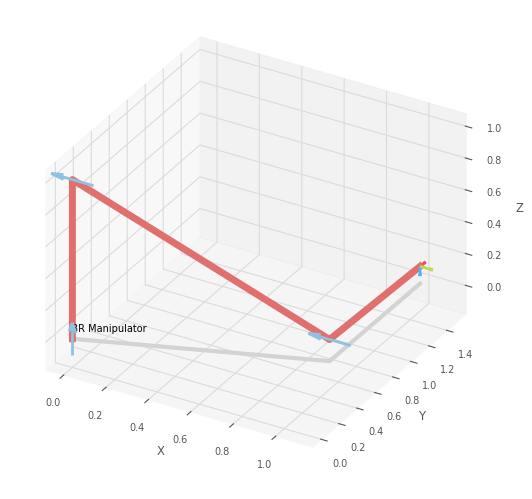

EEF position: [1.00478229 1.49976033 0.10796643]


<Figure size 640x480 with 0 Axes>

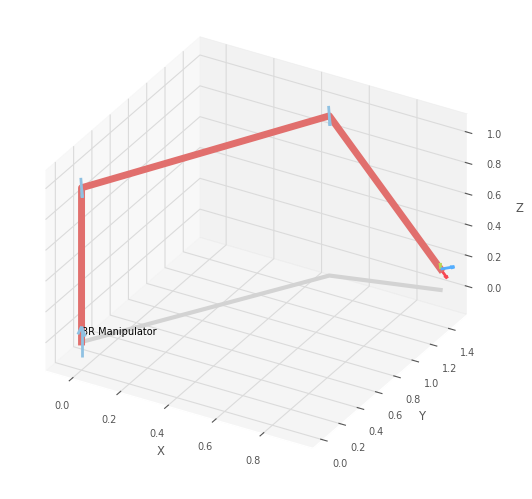

EEF position: [0.94022321 1.475093   0.13574319]


<Figure size 640x480 with 0 Axes>

In [276]:
for i, output in enumerate(outputs):
    robot.q = output
    eef_pos = robot.fkine(robot.q).t
    robot.plot(robot.q, backend="pyplot")
    print(f"EEF position: {eef_pos}")

## 3. Velocity Kinematics

#### 3.1 Computing linear and angular velocities 

In [277]:
theta1, theta2, theta3 = np.pi/4, np.pi/4, np.pi/4 
theta = [theta1, theta2, theta3]

DH = np.array([
    [theta1, 1, 0, np.pi/2], 
    [theta2, -1, 1, 0],      
    [theta3, 0, 1, -np.pi/2]  
])

T = [None] * 3  
R_matrices = [None] * 3 

for i in range(3):
    theta_link, d, a, alpha = DH[i]
    
    T_matrix = np.array([
        [np.cos(theta_link), -np.sin(theta_link) * np.cos(alpha), np.sin(theta_link) * np.sin(alpha), a * np.cos(theta_link)],
        [np.sin(theta_link), np.cos(theta_link) * np.cos(alpha), -np.cos(theta_link) * np.sin(alpha), a * np.sin(theta_link)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])
    
    T[i] = T_matrix[:3, 3]
    R_matrices[i] = T_matrix[:3, :3]
    
w = np.zeros((3, 1, 3))  # Angular velocities for 3 links
v = np.zeros((3, 1, 3))  # Linear velocities for 3 links

w[:, :, 0] = np.zeros((3, 1))
v[:, :, 0] = np.zeros((3, 1))

for i in range(1, 3):  
    w[:, :, i] = R_matrices[i-1] @ w[:, :, i-1] + np.array([0, 0, theta[i-1]]).reshape(-1, 1)
    v[:, :, i] = R_matrices[i-1] @ (v[:, :, i-1] + np.cross(w[:, :, i-1].flatten(), T[i-1]).reshape(-1, 1))

w[:, :, 2] = R_matrices[0] @ R_matrices[1] @ w[:, :, 1]
v[:, :, 2] = R_matrices[0] @ R_matrices[1] @ v[:, :, 1]

print("End-Effector Angular Velocity:")
print(w[:, :, 2])

print("End-Effector Linear Velocity:")
print(v[:, :, 2])


X = -np.sin(theta1) + np.cos(theta1)*np.cos(theta2) + np.cos(theta1)*np.cos(theta2+theta3)
Y = np.cos(theta1) + np.sin(theta1)*np.cos(theta2) + np.sin(theta1)*np.cos(theta2+theta3)
Z = 1 + np.sin(theta2) + np.sin(theta2+theta3)

Jv1 = np.array([
    [np.cos(theta1)*np.cos(theta2) + np.cos(theta1)*np.cos(theta2 + theta3), 
     -np.sin(theta1)*np.sin(theta2) - np.sin(theta1)*np.sin(theta2 + theta3), 
     -np.sin(theta1)*np.sin(theta2 + theta3)],
    
    [np.sin(theta1)*np.cos(theta2) + np.sin(theta1)*np.cos(theta2 + theta3),
     np.cos(theta1)*np.sin(theta2) + np.cos(theta1)*np.sin(theta2 + theta3), 
     np.cos(theta1)*np.sin(theta2 + theta3)],
    
    [-np.cos(theta2) - np.cos(theta2 + theta3), 
     -np.sin(theta2) - np.sin(theta2 + theta3), 
     -np.sin(theta2 + theta3)]
])

Full_Jacobian = np.vstack([Jv1, w[:, :, 2].flatten()])

print("Full Jacobian Matrix:")
print(Full_Jacobian)


End-Effector Angular Velocity:
[[ 5.55360367e-01]
 [-5.55360367e-01]
 [ 4.80917673e-17]]
End-Effector Linear Velocity:
[[0.]
 [0.]
 [0.]]
Full Jacobian Matrix:
[[ 5.00000000e-01 -1.20710678e+00 -7.07106781e-01]
 [ 5.00000000e-01  1.20710678e+00  7.07106781e-01]
 [-7.07106781e-01 -1.70710678e+00 -1.00000000e+00]
 [ 5.55360367e-01 -5.55360367e-01  4.80917673e-17]]


## 4. 2R Manipulator Dynamics

In [282]:
import numpy as np

# Define the parameters of the manipulator
m1 = 1.0 
m2 = 1.0 
l1 = 1.0  
l2 = 0.5 
lc1 = l1/2
lc2 = l2/2
I1 = (1/12) * m1 * (l1 ** 2)  
I2 = (1/12) * m2 * (l2 ** 2)  
g = 9.81 

theta1 = 0.5  
theta2 = 0.5  
theta1_dot = 0.0 
theta2_dot = 0.0  

theta = np.array([theta1, theta2])
theta_dot = np.array([theta1_dot, theta2_dot])

def compute_mass_matrix(theta1, theta2):
    return np.array([
        [I1 + I2 + m1*(lc1 ** 2) + m2*((l1 **2) + 2 * np.cos(theta2) * l1 * lc2 + (lc2 ** 2)), I2 + lc2 * (np.cos(theta2) * l1 + lc2) * m2],
        [I2 + lc2 * (np.cos(theta2) * l1 + lc2) * m2, I2 + (lc2 ** 2) * m2]
    ])
    
def compute_coriolis_matrix(theta1, theta2, theta1_dot, theta2_dot):
    return np.array([
        [-np.sin(theta2) * l1 * lc2 * theta2_dot * m2, -np.sin(theta2) * l1 * lc2 * m2 * (theta1_dot + theta2_dot)],
        [np.sin(theta2) * l1 * lc2 * theta1_dot * m2, 0]
    ])
    
def compute_gravitational_torque(theta1, theta2):
    return np.array([
        g * np.cos(theta1) * lc1 * m1 + g * (np.cos(theta1) * l1 + np.cos(theta1 + theta2) * lc2) * m2,
        g * np.cos(theta1 + theta2) * lc2 * m2
    ])
    

M = compute_mass_matrix(theta1, theta2)
C = compute_coriolis_matrix(theta1, theta2, theta1_dot, theta2_dot)
G = compute_gravitational_torque(theta1, theta2)

print("Mass Matrix M:")
print(M)
print("\nCoriolis Matrix C:")
print(C)
print("\nGravitational Torque Vector G:")
print(G)



Mass Matrix M:
[[1.85545795 0.30272897]
 [0.30272897 0.08333333]]

Coriolis Matrix C:
[[-0. -0.]
 [ 0.  0.]]

Gravitational Torque Vector G:
[14.2387188   1.32509141]


In [283]:
from scipy.integrate import solve_ivp

# Define initial conditions
q0 = [0.5, 0.5] 
v0 = [0.0, 0.0] 
y0 = q0 + v0     
torque = [1.5, -1.2] 

t_span = (0, 2)   
t_eval = np.linspace(0, 1, 50) 

def dynamics(t, y):
    q = y[:2]        
    v = y[2:]       

    M_matrix = compute_mass_matrix(q[0], q[1])
    C_matrix = compute_coriolis_matrix(q[0], q[1], v[0], v[1])
    G_vector = compute_gravitational_torque(q[0], q[1])
    
    M_inv = np.linalg.inv(M_matrix)

    q_ddot = M_inv @ (torque - C_matrix @ v - G_vector)

    return [v[0], v[1], q_ddot[0], q_ddot[1]]

# Solve the ODE using solve_ivp
solution = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='RK45')

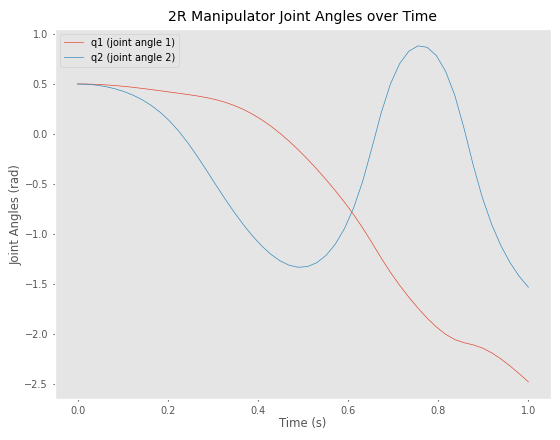

In [284]:
plt.plot(solution.t, solution.y[0], label='q1 (joint angle 1)')
plt.plot(solution.t, solution.y[1], label='q2 (joint angle 2)')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angles (rad)')
plt.legend()
plt.title('2R Manipulator Joint Angles over Time')
plt.grid()
plt.show()

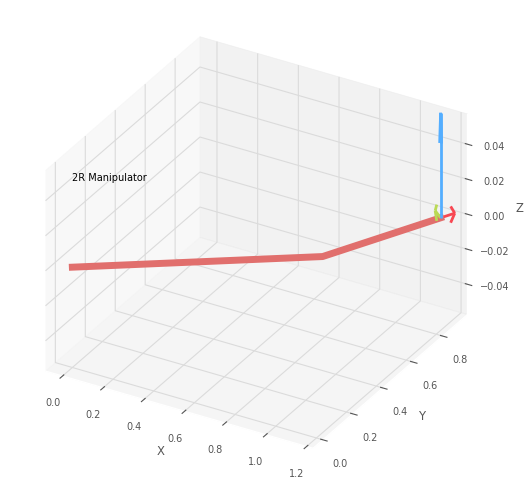

PyPlot3D backend, t = 2.499999999999999, scene:
  robot: Text(0.0, 0.0, '2R Manipulator')

<Figure size 640x480 with 0 Axes>

In [285]:

link1 = rtb.RevoluteDH(a=l1, alpha=0, offset=0, m=m1, r=[lc1, 0, 0], I=[I1, 0, 0, 0, 0, 0])
link2 = rtb.RevoluteDH(a=l2, alpha=0, offset=0, m=m2, r=[lc2, 0, 0], I=[I2, 0, 0, 0, 0, 0])
robot = rtb.DHRobot([link1, link2], name="2R Manipulator")
robot.q = np.array([0.5, 0.5])
                   
q1_vals = solution.y[0, :]
q2_vals = solution.y[1, :] 
q_vals = np.vstack([q1_vals, q2_vals]).T
q_vals.shape

robot.plot(q_vals, backend='pyplot', movie='2R.gif', jointaxes=False)